## Loading & Preprocessing

In [1]:
import numpy as np
import pandas as pd
import random
import requests
import zipfile
import io
import xgboost as xgb
import matplotlib as mpl
import itertools
import matplotlib.pylab as pl
from zipfile import ZipFile
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier
from matplotlib import pyplot
from matplotlib.pyplot import figure

In [2]:
# Set random seed throughout notebook
seed = 30
random.seed(seed)
np.random.seed(seed)

In [3]:
# Load data
r = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip', stream=True)
zf = zipfile.ZipFile(io.BytesIO(r.content))
data = pd.read_csv(zf.open('bank-additional/bank-additional-full.csv'), delimiter=';')
data = data.drop('duration', axis=1)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Prepare data for one hot encoding
features = data[['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']]

one_hot_encoder = OneHotEncoder().fit(features)

def onehot_encode(features, ohe=one_hot_encoder):
    col_names = ohe.get_feature_names_out(features.columns)
    feat_coded = pd.DataFrame(ohe.transform(features).toarray())
    feat_coded.columns = col_names
    return feat_coded

coded_features = onehot_encode(features)

In [5]:
# Transform data
data_onehot = data.drop(data[['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']], axis=1)
data_onehot = pd.concat([data_onehot, coded_features], axis=1)
le = LabelEncoder()
data_onehot['y'] = le.fit_transform(data_onehot['y'])

# Split into X & y train and test samples
X=data_onehot.drop(data_onehot[['y']], axis=1)
y=data_onehot[['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
print (f'X_train: {X_train.shape}')
print (f'y_train: {y_train.shape}')
print (f'X_test: {X_test.shape}')
print (f'y_test: {y_test.shape}')

X_train: (28831, 62)
y_train: (28831, 1)
X_test: (12357, 62)
y_test: (12357, 1)


## XGBoost Models

In [15]:
# Build and train untuned XGBoost model
xgb_model_raw = XGBClassifier(objective='binary:logistic', eval_metric='aucpr')
xgb_model_raw.fit(X_train, y_train)

# Evaluate raw model on test data
predictions = xgb_model_raw.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
xgb_model_raw_auc = auc(recall, precision)
print("Untuned XGB Precision-Recall AUC on Test Data: {}".format(round(xgb_model_raw_auc,4)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Untuned XGB Precision-Recall AUC on Test Data: 0.4893


In [16]:
# Drop features with low feature importance by SHAP
X_train_pruned = X_train.drop(['housing_no','housing_unknown','housing_yes','previous','loan_no','loan_unknown','loan_yes'], axis=1)
X_test_pruned = X_test.drop(['housing_no','housing_unknown','housing_yes','previous','loan_no','loan_unknown','loan_yes'], axis=1)


xgb_model_pruned = XGBClassifier(objective='binary:logistic', eval_metric='aucpr')
xgb_model_pruned.fit(X_train_pruned, y_train)

# Evaluate pruned model on test data
predictions = xgb_model_pruned.predict(X_test_pruned)
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
xgb_model_pruned_auc = auc(recall, precision)
print("Pruned XGB Precision-Recall AUC on Test Data: {}".format(round(xgb_model_pruned_auc,4)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Pruned XGB Precision-Recall AUC on Test Data: 0.4897


In [8]:
# Drop jobs features due to high correlation with other features
X_train_pruned_2 = X_train.drop(['housing_no','housing_unknown','housing_yes','previous','loan_no','loan_unknown','loan_yes','job_admin.','job_blue-collar','job_entrepreneur','job_housemaid','job_management','job_retired','job_self-employed','job_services','job_student','job_technician','job_unemployed','job_unknown'], axis=1)
X_test_pruned_2 = X_test.drop(['housing_no','housing_unknown','housing_yes','previous','loan_no','loan_unknown','loan_yes','job_admin.','job_blue-collar','job_entrepreneur','job_housemaid','job_management','job_retired','job_self-employed','job_services','job_student','job_technician','job_unemployed','job_unknown'], axis=1)


xgb_model_pruned_2 = XGBClassifier(objective='binary:logistic', eval_metric='aucpr')
xgb_model_pruned_2.fit(X_train_pruned_2, y_train)

# Evaluate pruned model on test data
predictions = xgb_model_pruned_2.predict(X_test_pruned_2)
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
xgb_model_pruned_2_auc = auc(recall, precision)
print("Further Pruned XGB Precision-Recall AUC on Test Data: {}".format(round(xgb_model_pruned_2_auc,4)))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Further Pruned XGB Precision-Recall AUC on Test Data: 0.4914


## Interpretability

### SHAP

In [13]:
import shap

In [17]:
# SHAP TreeExplainer for XGBoost
xgb_tree_explainer = shap.TreeExplainer(xgb_model_raw)
xgb_tree_shap_values = xgb_tree_explainer(X_train)

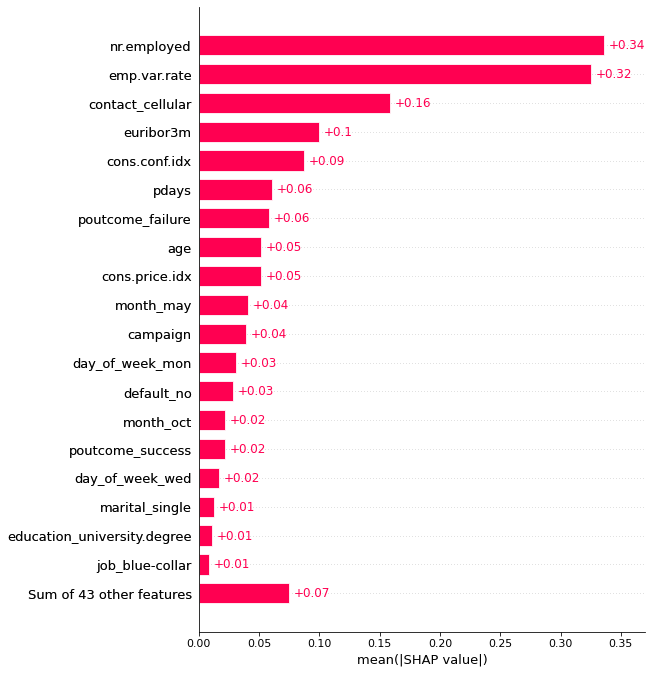

In [18]:
# Raw Feature importance using SHAP
shap.plots.bar(xgb_tree_shap_values, max_display=20)

In [19]:
# Group together variables to reproduce originals
xgb_shap_values = xgb_tree_explainer.shap_values(X_train)

raw_feature_shap = {}

for i in range (len(X_train.columns)):
  raw_feature_shap[i] = round(np.absolute(xgb_shap_values[:,i]).mean(),4)

# Define individual variables & variable groups
age = raw_feature_shap.get(0)
campaign = raw_feature_shap.get(1)
pdays = raw_feature_shap.get(2)
previous = raw_feature_shap.get(3)
emp_var_rate = raw_feature_shap.get(4)
cons_price_idx = raw_feature_shap.get(5)
cons_conf_idx = raw_feature_shap.get(6)
euribor3m = raw_feature_shap.get(7)
nr_employed = raw_feature_shap.get(8)

keys = list(range(9,21))
values = [raw_feature_shap.get(key) for key in keys]
job = round(sum(values),4)

keys = list(range(21,25))
values = [raw_feature_shap.get(key) for key in keys]
marital = round(sum(values),4)

keys = list(range(25,33))
values = [raw_feature_shap.get(key) for key in keys]
education = round(sum(values),4)

keys = list(range(33,36))
values = [raw_feature_shap.get(key) for key in keys]
default = round(sum(values),4)

keys = list(range(36,39))
values = [raw_feature_shap.get(key) for key in keys]
housing = round(sum(values),4)

keys = list(range(39,42))
values = [raw_feature_shap.get(key) for key in keys]
loan = round(sum(values),4)

keys = list(range(42,44))
values = [raw_feature_shap.get(key) for key in keys]
contact = round(sum(values),4)

keys = list(range(44,54))
values = [raw_feature_shap.get(key) for key in keys]
month = round(sum(values),4)

keys = list(range(54,59))
values = [raw_feature_shap.get(key) for key in keys]
day_of_week = round(sum(values),4)

keys = list(range(59,62))
values = [raw_feature_shap.get(key) for key in keys]
poutcome = round(sum(values),4)

features = ('age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome')
values = [age, campaign, pdays, previous, emp_var_rate, cons_price_idx, cons_conf_idx, euribor3m, nr_employed, job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome]
shap_dict = {}
for key in features:
    for value in values:
        shap_dict[key] = value
        values.remove(value)
        break

shap_grouped = sorted(shap_dict.items(), key=lambda x:x[1], reverse=True)

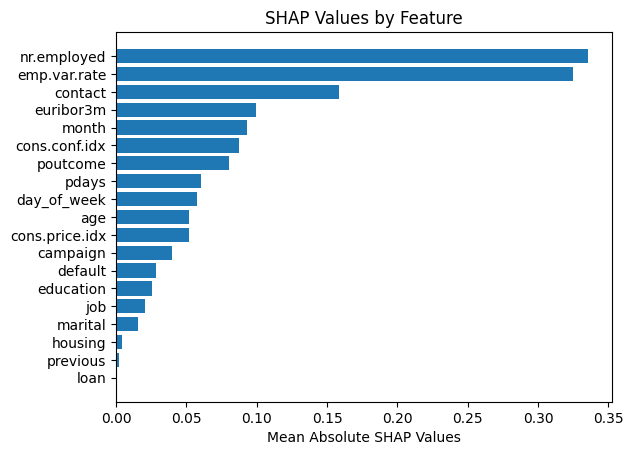

In [20]:
# Plot grouped features
features, values = zip(*shap_grouped)

pyplot.rcdefaults()
fig, ax = pyplot.subplots()
y_pos = np.arange(len(features))

# df_sorted = df.sort_values('values')
ax.barh(y_pos, values, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()
ax.set_xlabel('Mean Absolute SHAP Values')
ax.set_title('SHAP Values by Feature')

pyplot.show()

In [12]:
# SHAP pruned features
xgb_explainer = shap.Explainer(xgb_model_pruned)
xgb_shap_values = xgb_explainer(X_test_pruned)

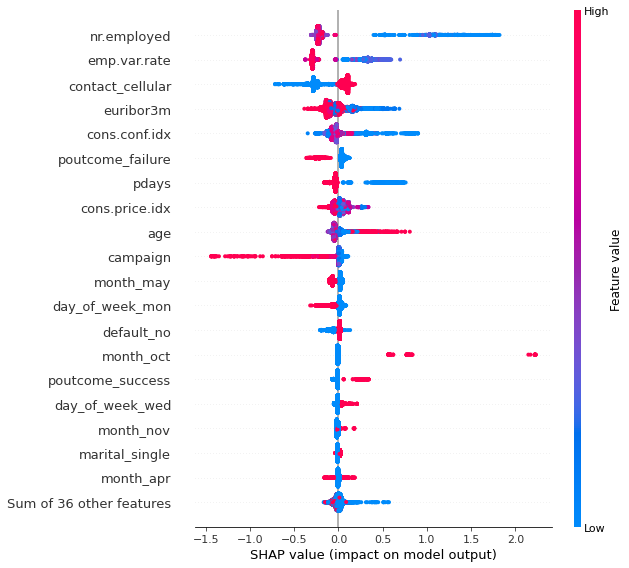

In [13]:
shap.plots.beeswarm(xgb_shap_values, max_display=20)

In [94]:
# SHAP interaction effect configuration
n = 10000 # sample size
sample = random.sample(range(0, len(X_train_pruned_2)), n)
shap_interaction_values = shap.TreeExplainer(xgb_model_pruned_2).shap_interaction_values(X_train_pruned_2.iloc[sample])


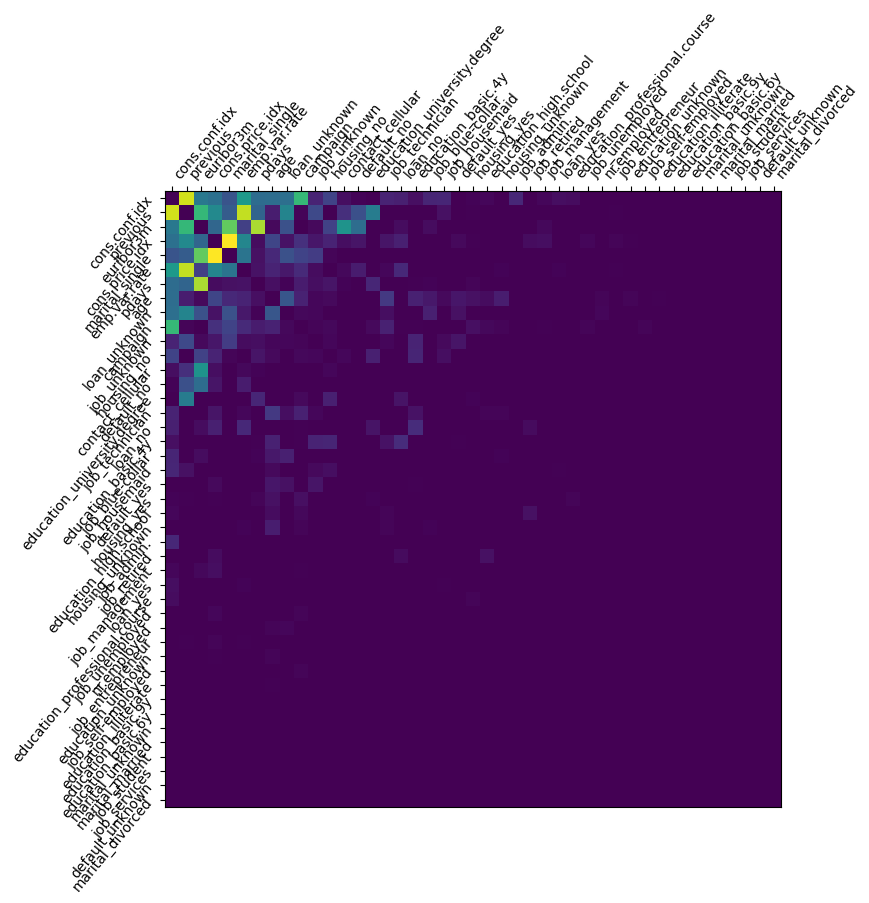

In [28]:
# SHAP interaction effect between all variables
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(8,8))
pl.set_cmap('viridis')
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), X_train.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X_train.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

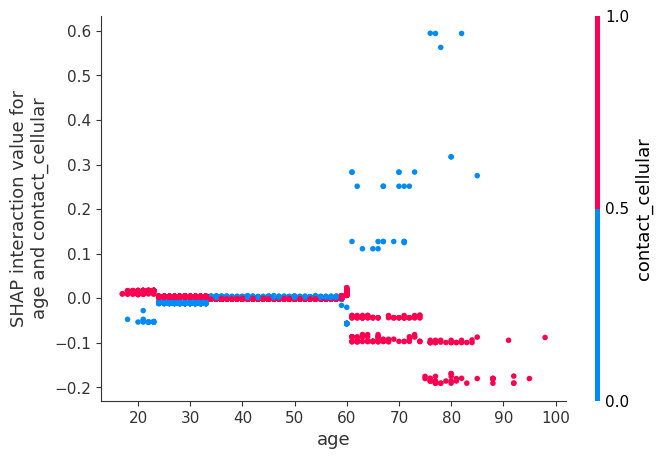

In [95]:
# SHAP interaction between selected variables
shap.dependence_plot(("age", "contact_cellular"), shap_interaction_values, X_train_pruned_2.iloc[sample])

## ALE

In [ ]:
import alibi
import PyALE
from PyALE import ale
from alibi.explainers import PartialDependence, plot_pd

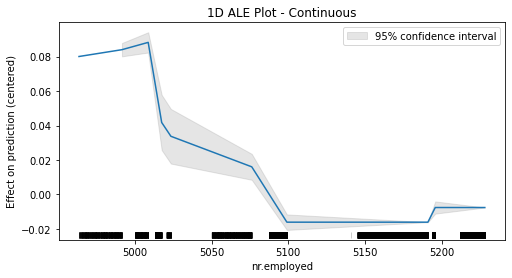

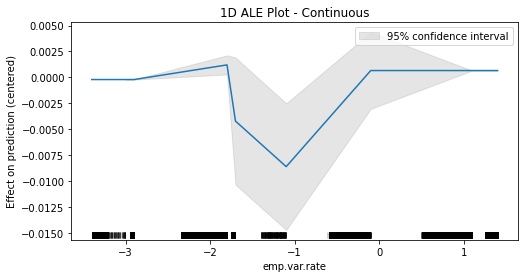

In [ ]:
# ALE for continuous feature
ale_eff = ale(X=X_train, model=xgb_model_raw, feature=["nr.employed"], feature_type="continuous", grid_size=500, include_CI=True, C=0.95)
ale_eff_2 = ale(X=X_train, model=xgb_model_raw, feature=["emp.var.rate"], feature_type="continuous", grid_size=500, include_CI=True, C=0.95)

INFO:PyALE._ALE_generic:categorical feature detected.


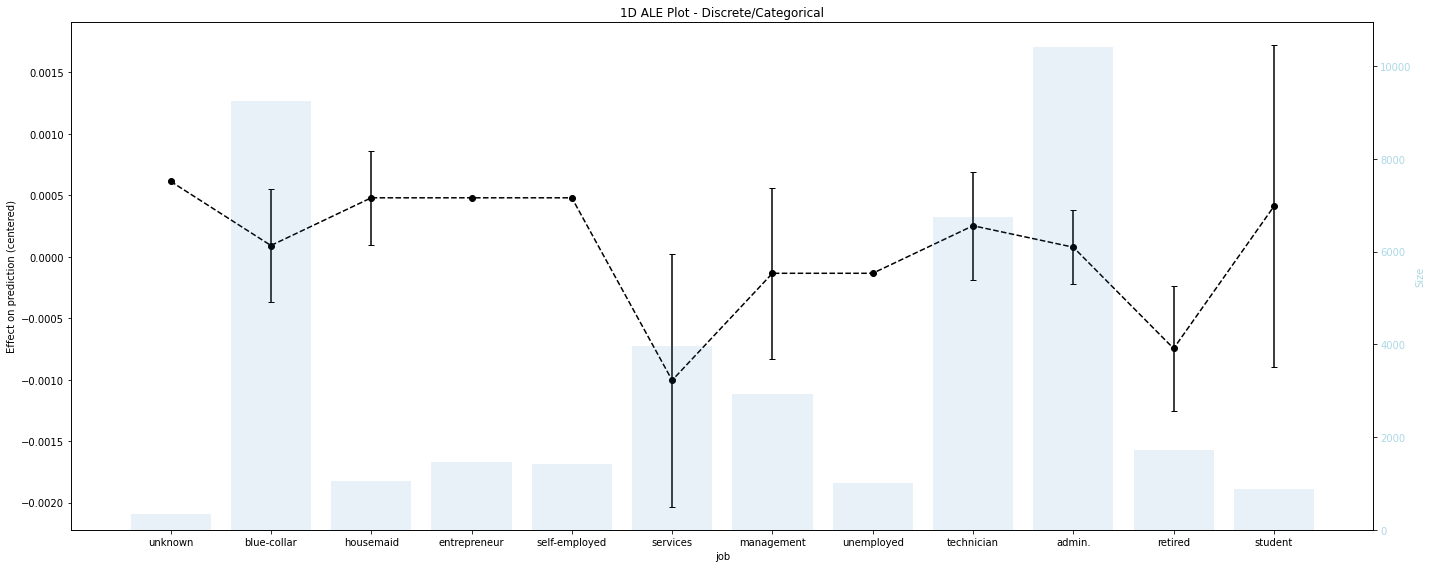

In [ ]:
# ALE for categorical features

# select categorical feature
selected_feature = 'job'
ale_feature = data[[selected_feature]]

# processing
ale_one_hot_encoder = OneHotEncoder().fit(ale_feature)
col_names = ale_one_hot_encoder.get_feature_names_out(ale_feature.columns)
X_feat_raw = X_train.drop(X_train[col_names], axis=1)
X_feat_raw = pd.concat([X_feat_raw, ale_feature], axis=1)
names = X_train.columns

def ale_onehot_encode(features, ohe=ale_one_hot_encoder):
    col_names = ohe.get_feature_names_out(features.columns)
    feat_coded = pd.DataFrame(ohe.transform(features).toarray())
    feat_coded.columns = col_names
    return feat_coded

# produce 1D ALE plot
fig, (ax1) = pyplot.subplots(1, 1, figsize=(20, 8))
ale_eff_1 = ale(X=X_feat_raw, 
              model=xgb_model_raw, 
              feature=[selected_feature], 
              encode_fun=ale_onehot_encode, 
              predictors=names,
              grid_size=500, 
              include_CI=True, 
              C=0.95,
              plot=True,
              fig=fig,
              ax=ax1
             )

### PDP/ICE

In [47]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from alibi.explainers import PartialDependence, plot_pd

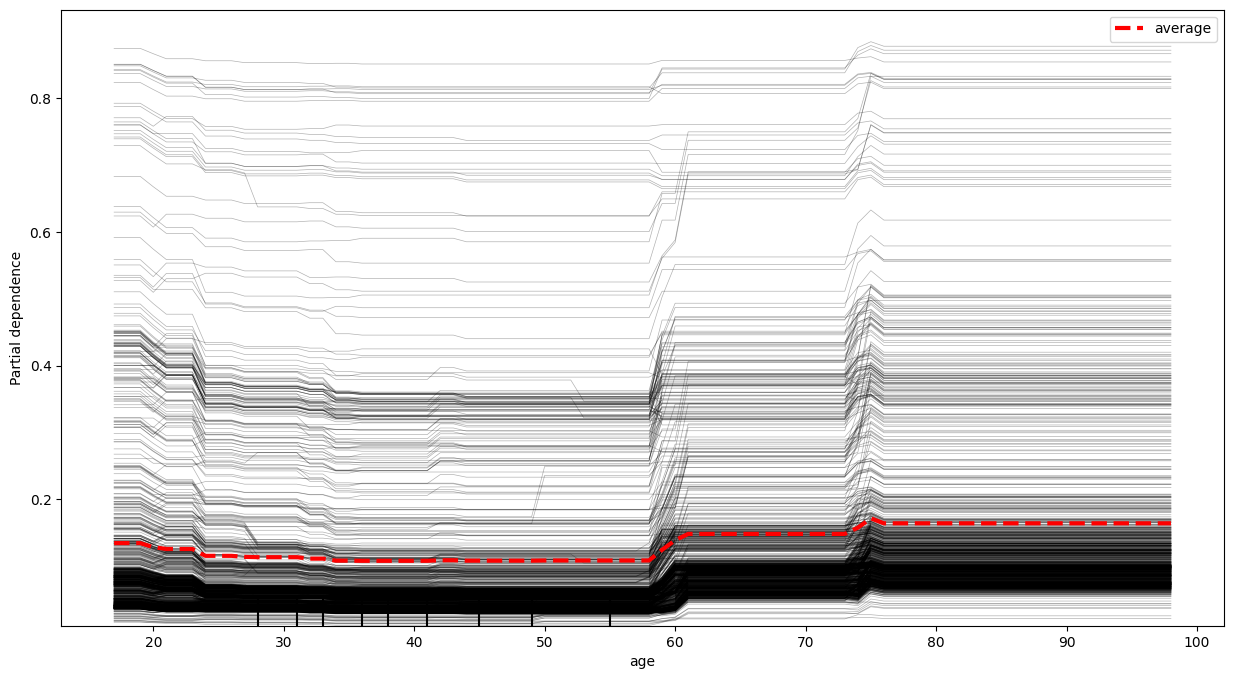

In [36]:
# PDP/ICE for continuous variables
features = ['age']
fig, ax = pyplot.subplots(figsize=(15,8))
display = PartialDependenceDisplay.from_estimator(xgb_model_raw, X_train, features, kind='both', ice_lines_kw={"color":"black"}, pd_line_kw={"color":"red", "lw":3, 'linestyle':'--'}, ax=ax)

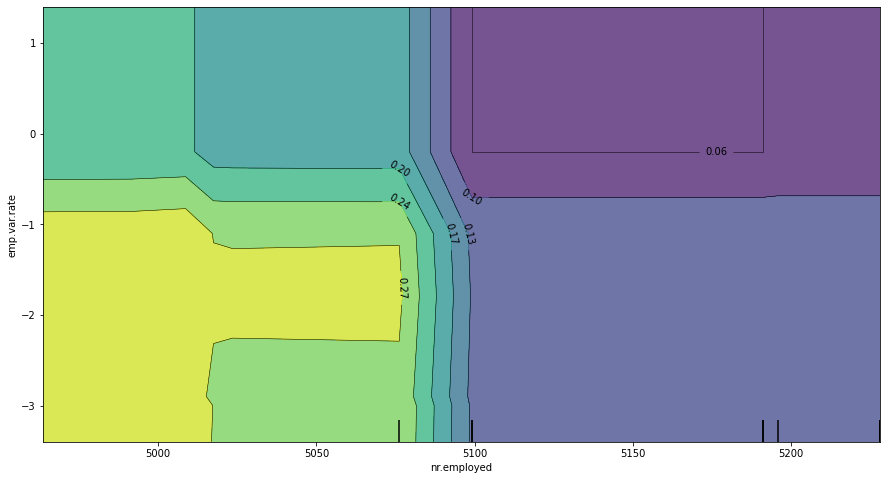

In [ ]:
# Two dimensional PDP
features = [('nr.employed', 'emp.var.rate')]
fig, ax = pyplot.subplots(figsize=(15,8))
display = PartialDependenceDisplay.from_estimator(xgb_model_raw, X_train, features, kind='average', ax=ax)

In [68]:
# PDP for categorical variables

# processing
X_data = data.drop(data[['y']], axis=1)
feature_names = data.columns.tolist()
x_feature_names = X_data.columns.tolist()
categorical_columns_names=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [feature_names.index(fn) for fn in x_feature_names if fn not in categorical_columns_names]
oe = OrdinalEncoder().fit(X_data[categorical_columns_names])
X_data.loc[:,categorical_columns_names]=oe.transform(X_data[categorical_columns_names])
X_data = X_data.to_numpy()
categorical_names = {i:list(v) for (i,v) in zip(categorical_columns_indices, oe.categories_)}
cat_transf = OneHotEncoder(categories=[range(len(x)) for x in categorical_names.values()], handle_unknown='ignore')

num_transf = StandardScaler()

preprocessor=ColumnTransformer(
    transformers=[ 
        ('cat', cat_transf, categorical_columns_indices),
        ('num', num_transf, numerical_columns_indices)
    ],
    sparse_threshold=0
)
preprocessor.fit(X_data)
prediction_fn = lambda x: xgb_model_raw.predict(preprocessor.transform(x))
target_names = ['y']
explainer = PartialDependence(predictor=prediction_fn, feature_names=x_feature_names, target_names=target_names, categorical_names=categorical_names)

In [ ]:
# Plot PDP for categorical feature
features = [feature_names.index('education')]
exp = explainer.explain(X=X_data, features=features, kind='average')
plot_pd(exp=exp, n_ice=100, fig_kw={'figheight':10,'figwidth':15}, center=True)

In [ ]:
# Plot two dimensoinal PDP for categorical features
features = [(feature_names.index('job'),feature_names.index('education'))]
exp = explainer.explain(X=X_data, features=features, kind='average')
plot_pd(exp=exp, n_ice=100, center=True, pd_cat_cat_kw={'cmap':'RdYlGn'}, fig_kw={'figheight':10,'figwidth':15})

### Friedman's H-Statistic

In [32]:
# Calculate two-way Friedman's H Statistic for all pairs
i = 4 # first variable
j = 8 # second variable
n = 5000 # sample size
sample = random.sample(range(0, len(X_train_pruned)), n)

univariate = {}
for i in range(X_train_pruned.shape[1]):
  univariate[i] = partial_dependence(xgb_model_pruned, X_train_pruned.iloc[sample], features=[i], kind='average')['average']
    
bivariate = {}
for i, j in itertools.combinations(range(X_train_pruned.shape[1]), 2):
  bivariate[(i, j)] = partial_dependence(xgb_model_pruned, X_train_pruned.iloc[sample], features=[i, j], kind='average')['average']

h = np.zeros((X_train_pruned.shape[1], X_train_pruned.shape[1]))
for i, j in itertools.combinations(range(X_train_pruned.shape[1]), 2):
  h[i, j] = ((bivariate[(i, j)] - univariate[i].reshape(1, -1, 1) - univariate[j].reshape(1, 1, -1) + y_train.iloc[sample].to_numpy().mean() ) ** 2).sum() / ((bivariate[(i, j)] - y_train.iloc[sample].to_numpy().mean())** 2).sum()

In [33]:
h_scores={}

def compile_h_scores(i, j):
  for i, j in itertools.combinations(range(X_train_pruned.shape[1]), 2):
    h_scores[i,j] = round(h[i,j],4)

compile_h_scores(X_train_pruned.shape[1], X_train_pruned.shape[1])

top_20_h_scores = sorted(h_scores, key=h_scores.get, reverse=True)[:20]

# return 20 highest interactions by Friedman's H score
def top_20_h_scores():
    print("Top 20 Friedman's H Score Interactions")
    top_20_h_scores = sorted(h_scores, key=h_scores.get, reverse=True)[:20]
    for i in range(20):
        key = top_20_h_scores[i]
        value = h_scores[key]
        columns = list(X_train_pruned.columns[[top_20_h_scores[i]]])
        print(f"H Score: {value}, Variables: {columns[0]}, {columns[1]}")
#        print(f"H Score: {value}, Indices: {key}")

print(top_20_h_scores())

Top 20 Friedman's H Score Interactions
H Score: 2.5566, Variables: job_housemaid, job_unknown
H Score: 2.5378, Variables: job_unemployed, job_unknown
H Score: 2.3605, Variables: job_housemaid, job_unemployed
H Score: 2.2225, Variables: job_unknown, day_of_week_fri
H Score: 2.207, Variables: job_unknown, education_basic.9y
H Score: 2.2046, Variables: job_unknown, education_high.school
H Score: 2.1766, Variables: job_unknown, month_aug
H Score: 2.1765, Variables: job_housemaid, month_aug
H Score: 2.1266, Variables: job_unknown, day_of_week_thu
H Score: 2.1255, Variables: job_housemaid, day_of_week_fri
H Score: 2.0696, Variables: job_unknown, education_basic.6y
H Score: 2.049, Variables: job_housemaid, education_high.school
H Score: 2.0368, Variables: job_housemaid, education_basic.9y
H Score: 2.0187, Variables: job_unemployed, month_aug
H Score: 1.9511, Variables: job_retired, job_unknown
H Score: 1.9108, Variables: job_entrepreneur, job_unknown
H Score: 1.9108, Variables: job_management

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
